In [1]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)

# Define folders
train_dir = os.path.join(path, "chest_xray", "train")
val_dir   = os.path.join(path, "chest_xray", "val")
test_dir  = os.path.join(path, "chest_xray", "test")

print("Train:", train_dir)
print("Val:", val_dir)
print("Test:", test_dir)
print("Train classes:", os.listdir(train_dir))


Path to dataset files: C:\Users\USER PC\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2
Train: C:\Users\USER PC\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\train
Val: C:\Users\USER PC\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\val
Test: C:\Users\USER PC\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\test
Train classes: ['NORMAL', 'PNEUMONIA']


Data Exploration

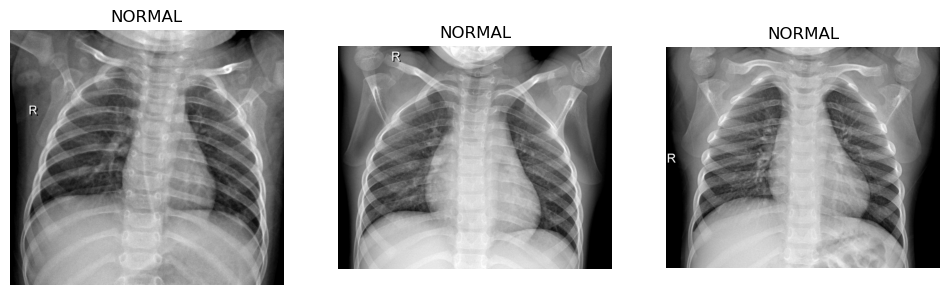

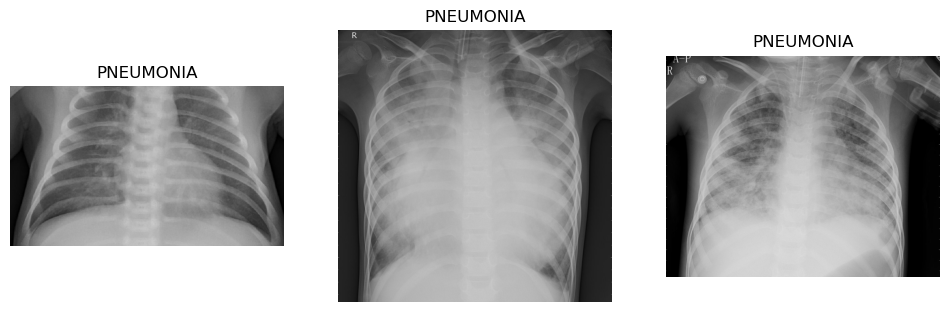

In [2]:
#: Load dataset + display 3 images from each class (NORMAL / PNEUMONIA).
import matplotlib.pyplot as plt
import random
from PIL import Image

classes = ["NORMAL", "PNEUMONIA"]

def show_images_from_class(base_dir, class_name, n=3):
    class_path = os.path.join(base_dir, class_name)
    images = os.listdir(class_path)
    chosen = random.sample(images, n)

    plt.figure(figsize=(12,4))
    for i, img_name in enumerate(chosen):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path).convert("RGB")
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(class_name)
    plt.show()

# Show 3 images from each class (from train set)
for c in classes:
    show_images_from_class(train_dir, c, n=3)


Train counts: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Val counts: {'NORMAL': 8, 'PNEUMONIA': 8}
Test counts: {'NORMAL': 234, 'PNEUMONIA': 390}


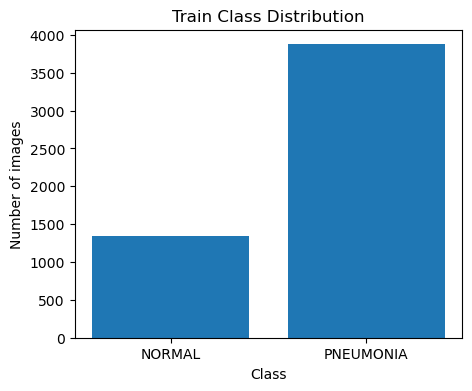

In [3]:
#Analyze data: Are classes balanced? What challenges observed?
from collections import Counter

def count_images(base_dir):
    counts = {}
    for c in classes:
        counts[c] = len(os.listdir(os.path.join(base_dir, c)))
    return counts

train_counts = count_images(train_dir)
val_counts   = count_images(val_dir)
test_counts  = count_images(test_dir)

print("Train counts:", train_counts)
print("Val counts:", val_counts)
print("Test counts:", test_counts)

# Quick bar plot for train
plt.figure(figsize=(5,4))
plt.bar(train_counts.keys(), train_counts.values())
plt.title("Train Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()

Data Preprocessing

In [4]:
#Resize to 224×224 + Normalize pixel values.
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode="binary"   # binary labels (0/1)
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode="binary"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,        # مهم للتقييم والـ confusion matrix
    label_mode="binary"
)

# Normalize layer
normalizer = tf.keras.layers.Rescaling(1./255)

# Apply normalization
train_ds = train_ds.map(lambda x, y: (normalizer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalizer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalizer(x), y))

# Performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

C:\Users\USER PC\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [5]:
#: Apply data augmentation (rotation, zoom, horizontal flip).
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.10),
])

In [6]:
#CNN فيها ≥3 Conv + ReLU + MaxPooling + Fully Connected (Sequential API).
from tensorflow.keras import layers, models

def build_base_model():
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),

        # Augmentation داخل المودل (يتطبق فقط أثناء التدريب)
        data_augmentation,

        # Conv Block 1
        layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(),

        # Conv Block 2
        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(),

        # Conv Block 3
        layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(),

        # Classifier
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid")  # Binary classification
    ])
    return model

base_model = build_base_model()
base_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,561 (49.36 MB)

 Trainable params: 12,938,561 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

Model Training

In [7]:
base_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)

EPOCHS = 10  
history_base = base_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 368s 2s/step - accuracy: 0.8198 - loss: 0.4025 - val_accuracy: 0.7500 - val_loss: 0.5534
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.9189 - loss: 0.2029 - val_accuracy: 0.9375 - val_loss: 0.3173
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.9352 - loss: 0.1654 - val_accuracy: 0.9375 - val_loss: 0.2365
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.9440 - loss: 0.1497 - val_accuracy: 0.6250 - val_loss: 0.5812
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.9454 - loss: 0.1460 - val_accuracy: 0.7500 - val_loss: 0.4592
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2938s 18s/step - accuracy: 0.9480 - loss: 0.1337 - val_accuracy: 1.0000 - val_loss: 0.1660
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - accuracy: 0.9488 - loss: 0.1342 - val_accuracy: 0.7500 - val_loss: 0.5322
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.9534 - loss: 0.1208 - val_ac

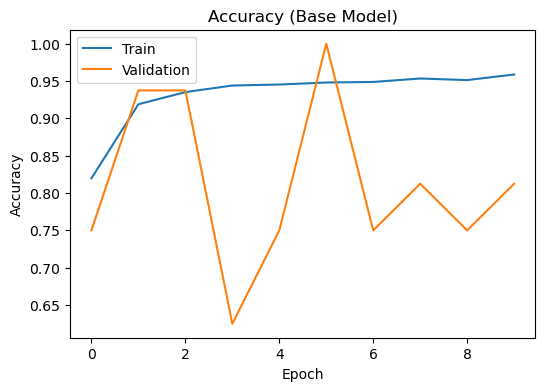

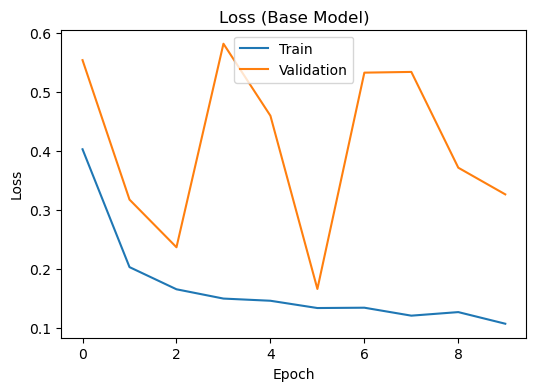

In [8]:
#Plot training vs validation accuracy/loss.
import matplotlib.pyplot as plt

def plot_history(history, title_suffix=""):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    plt.figure(figsize=(6,4))
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title(f"Accuracy {title_suffix}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Train", "Validation"])
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title(f"Loss {title_suffix}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Train", "Validation"])
    plt.show()

plot_history(history_base, "(Base Model)")


Model Evaluation (Test Set)

In [9]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Predict probabilities
y_prob = base_model.predict(test_ds).ravel()

# Convert to class labels (0/1)
y_pred = (y_prob >= 0.5).astype(int)

# True labels
y_true = np.concatenate([y.numpy().astype(int).ravel() for x, y in test_ds], axis=0)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1-score:", f1_score(y_true, y_pred))

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 554ms/step
Accuracy: 0.8477564102564102
Precision: 0.814498933901919
Recall: 0.9794871794871794
F1-score: 0.889406286379511

Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.95      0.63      0.76       234
   PNEUMONIA       0.81      0.98      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.80      0.82       624
weighted avg       0.86      0.85      0.84       624



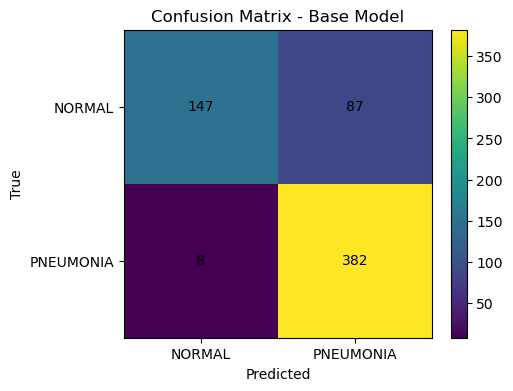

In [10]:
#Confusion Matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title("Confusion Matrix - Base Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0,1], ["NORMAL", "PNEUMONIA"])
plt.yticks([0,1], ["NORMAL", "PNEUMONIA"])

for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")

plt.colorbar()
plt.show()


Handling Overfitting (Dropout)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.7395 - loss: 0.5518 - val_accuracy: 0.5000 - val_loss: 0.6559
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - accuracy: 0.7809 - loss: 0.4194 - val_accuracy: 0.6250 - val_loss: 0.6260
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.8138 - loss: 0.4005 - val_accuracy: 0.6250 - val_loss: 0.6380
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2324s 3s/step - accuracy: 0.8359 - loss: 0.3701 - val_accuracy: 0.6250 - val_loss: 0.6296
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 448s 2s/step - accuracy: 0.8278 - loss: 0.3760 - val_accuracy: 0.6250 - val_loss: 0.6175
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.8474 - loss: 0.3583 - val_accuracy: 0.6250 - val_loss: 0.6553
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 407s 2s/step - accuracy: 0.8543 - loss: 0.3471 - val_accuracy: 0.7500 - val_loss: 0.6408
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - accuracy: 0.8560 - loss: 0.3426 - val_acc

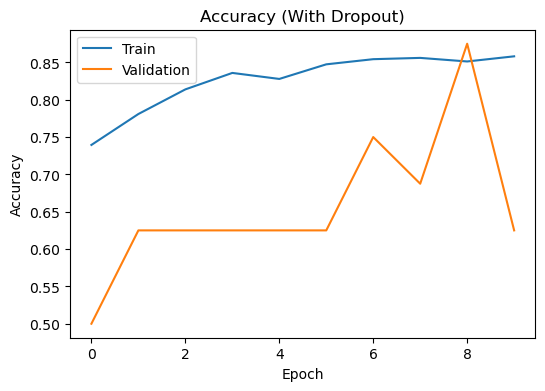

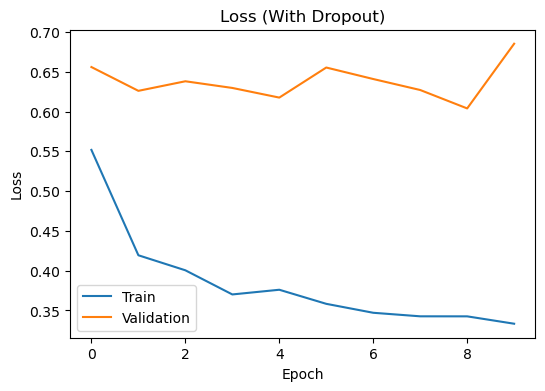

In [11]:
#Apply Dropout + Compare results before/after.
def build_dropout_model():
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        data_augmentation,

        layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

drop_model = build_dropout_model()
drop_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)

history_drop = drop_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

plot_history(history_drop, "(With Dropout)")


In [12]:
# Evaluate Dropout model
y_prob_d = drop_model.predict(test_ds).ravel()
y_pred_d = (y_prob_d >= 0.5).astype(int)

print("=== Base Model Metrics ===")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1:", f1_score(y_true, y_pred))

print("\n=== Dropout Model Metrics ===")
print("Accuracy:", accuracy_score(y_true, y_pred_d))
print("Precision:", precision_score(y_true, y_pred_d))
print("Recall:", recall_score(y_true, y_pred_d))
print("F1:", f1_score(y_true, y_pred_d))

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 495ms/step
=== Base Model Metrics ===
Accuracy: 0.8477564102564102
Precision: 0.814498933901919
Recall: 0.9794871794871794
F1: 0.889406286379511

=== Dropout Model Metrics ===
Accuracy: 0.7628205128205128
Precision: 0.7354085603112841
Recall: 0.9692307692307692
F1: 0.8362831858407079


In [ ]:
# ============================================================
# IMPROVEMENT CODE ONLY (CNN from scratch)
# Requirements already defined:
# train_ds, val_ds, test_ds, data_augmentation, class_names
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras import layers, models, regularizers

# -----------------------------
# 1) Build Improved CNN
# -----------------------------
def build_improved_cnn():
    L2 = 1e-4
    model = models.Sequential([
        layers.Input(shape=(224,224,3)),
        data_augmentation,

        # Block 1
        layers.Conv2D(32, (3,3), padding="same", kernel_regularizer=regularizers.l2(L2)),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.15),

        # Block 2
        layers.Conv2D(64, (3,3), padding="same", kernel_regularizer=regularizers.l2(L2)),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.20),

        # Block 3
        layers.Conv2D(128, (3,3), padding="same", kernel_regularizer=regularizers.l2(L2)),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        # Head
        layers.Flatten(),
        layers.Dense(128, kernel_regularizer=regularizers.l2(L2)),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dropout(0.30),

        layers.Dense(1, activation="sigmoid")
    ])
    return model

model_improved = build_improved_cnn()

# -----------------------------
# 2) Compile
# -----------------------------
model_improved.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)

# -----------------------------
# 3) Class Weights (to help NORMAL recall)
# -----------------------------
y_train_list = []
for _, y in train_ds.unbatch().batch(2048):
    y_train_list.append(y.numpy().astype(int).ravel())
y_train_all = np.concatenate(y_train_list, axis=0)

counts = Counter(y_train_all)
total = sum(counts.values())
class_weight = {
    0: total / (2 * counts[0]),   # NORMAL
    1: total / (2 * counts[1])    # PNEUMONIA
}
print("Class weights:", class_weight)

# -----------------------------
# 4) Callbacks (stop at best epoch)
# -----------------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_improved_cnn.keras", monitor="val_loss", save_best_only=True
    )
]

# -----------------------------
# 5) Train
# -----------------------------
EPOCHS = 30
history_improved = model_improved.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight
)

# -----------------------------
# 6) Plot Accuracy/Loss
# -----------------------------
def plot_history(hist, title="Improved CNN"):
    plt.figure(figsize=(6,4))
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Train", "Validation"])
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Train", "Validation"])
    plt.show()

plot_history(history_improved)

# -----------------------------
# 7) Evaluate on Test
# -----------------------------
y_prob = model_improved.predict(test_ds).ravel()
y_pred = (y_prob >= 0.5).astype(int)
y_true = np.concatenate([y.numpy().astype(int).ravel() for x, y in test_ds], axis=0)

print("\n=== Improved CNN Metrics (threshold=0.5) ===")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1-score:", f1_score(y_true, y_pred))

print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title("Confusion Matrix - Improved CNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0,1], class_names)
plt.yticks([0,1], class_names)
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.colorbar()
plt.show()

Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}
Epoch 1/30
 27/163 ━━━━━━━━━━━━━━━━━━━━ 8:41 4s/step - accuracy: 0.7734 - loss: 0.5529